<a href="https://colab.research.google.com/github/carolynw898/STAT946Proj/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import torch

n_embd = 512
timesteps = 1000
batch_size = 256
learning_rate = 1e-4
num_epochs = 5
blockSize = 200
testBlockSize = 400
numVars = 5
numYs = 1
numPoints = 200
target = 'Skeleton'
const_range = [-2.1, 2.1] # constant range to generate during training only if target is Skeleton
decimals = 8 # decimals of the points only if target is Skeleton
trainRange = [-3.0,3.0] # support range to generate during training only if target is Skeleton
addVars = False
maxNumFiles = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
dataDir = "/content/drive/MyDrive/Colab/STAT946_proj/data"
dataFolder = "1_5_var_dataset"

In [20]:
from torch.utils.data import DataLoader
import numpy as np
import glob
from utils import processDataFiles, CharDataset, tokenize_equation
import random
import json

path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
text = text.split('\n') # convert the raw text to a set of examples
# skeletons = []
skeletons = [json.loads(item)['Skeleton'] for item in text if item.strip()]
all_tokens = set()
for eq in skeletons:
    all_tokens.update(tokenize_equation(eq))
integers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
all_tokens.update(integers)  # add all integers to the token set
tokens = sorted(list(all_tokens) + ['_', 'T', '<', '>', ':'])  # special tokens
trainText = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(trainText) # shuffle the dataset, it's important specailly for the combined number of variables experiment

In [21]:
train_dataset = CharDataset(trainText, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points, variables = train_dataset.__getitem__(idx)
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

data has 2262058 examples, 44 unique.
id:1166655
outputs:C*x1**5+C*x1**4+C*x1**3+C*x1**2+C*x1+C>__________________________________________________________________________________________________________________________________________________________________________
variables:1


In [22]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

# print a random sample
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points, variables = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=2
    )

data has 193 examples, 44 unique.
tensor(-5.4563) tensor(2.9524)
id:34
outputs:C*exp(C*sin(C*log(C*x3+C)))+C>_________________________________________________________________________________________________________________________________________________________________________________
variables:3


In [23]:
import torch
import json
from scipy.optimize import minimize
from math import log
import math
from utils import relativeErr, lossFunc
import numpy as np
from sympy import sympify, Symbol, sin, cos, log, exp


def validate_prediction(
    skeleton, variables=["x1", "x2", "x3", "x4", "x5"], constant_symbol="C"
):
    local_dict = {var: Symbol(var) for var in variables}
    local_dict[constant_symbol] = Symbol(constant_symbol)

    local_dict.update(
        {
            "sin": sin,
            "cos": cos,
            "log": log,
            "exp": exp,
        }
    )

    try:
        expr = sympify(
            skeleton, locals=local_dict, evaluate=False, convert_xor=True
        )
    except Exception as e:
        return False

    return True

SAFE_GLOBALS = {
    'sin': math.sin,
    'cos': math.cos,
    'tan': math.tan,
    'log': math.log,
    'exp': math.exp,
    'sqrt': math.sqrt,
    'abs': abs,
    'pow': pow,
    '__builtins__': {}
}

@torch.no_grad()
def test_model(model, test_loader, textTest, train_dataset, device):
    results = {"target": [], "target_skeleton": [], "predicted_skeleton": [], "predicted": [], "error": []}
    for batch_idx, (_, tokens, points, variables) in enumerate(test_loader):
        points = points.to(device)
        tokens = tokens.to(device)
        variables = variables.to(device)
        B = points.shape[0]
        predicted_skeletons = model.sample(points, variables, train_dataset, B)

        for i in range(B):
            t = json.loads(textTest[batch_idx * test_loader.batch_size + i])
            eq = t["EQ"]

            eq_skeleton = ''.join([train_dataset.itos[int(i)] for i in tokens[0]])
            eq_skeleton = eq_skeleton.strip(train_dataset.paddingToken).split('>')
            eq_skeleton = eq_skeleton[0] #if len(eq[0])>=1 else eq[1]
            eq_skeleton = eq_skeleton.strip('<').strip(">")

            # Predicted
            predicted_skeleton = predicted_skeletons[i]
            predicted = predicted_skeleton

            #if not validate_prediction(predicted_skeleton):
            #    continue

            # Fit constants
            c = [1.0 for i,x in enumerate(predicted) if x=='C'] # initialize coefficients as 1
            # c[-1] = 0 # initialize the constant as zero
            b = [(-2,2) for i,x in enumerate(predicted) if x=='C']  # bounds on variables
            try:
                if len(c) != 0:
                    # This is the bottleneck in our algorithm
                    # for easier comparison, we are using minimize package
                    cHat = minimize(lossFunc, c, #bounds=b,
                                args=(predicted, t['X'], t['Y']))

                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except ValueError:
                continue
                raise 'Err: Wrong Equation {}'.format(predicted)
            except Exception as e:
                continue
                raise 'Err: Wrong Equation {}, Err: {}'.format(predicted, e)

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = eq + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                             raise ValueError('There is a , in the equation!')
                    YEval = eval(eqTmp, SAFE_GLOBALS)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    #print('TA: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    #print(i)
                    #raise
                    continue # if there is any point in the target equation that has any problem, ignore it
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp, SAFE_GLOBALS)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    #print('PR: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    Yhat = 100
                Yhats.append(Yhat)

            # Compute error and store results
            err = relativeErr(Ys,Yhats, info=True)

            if type(err) is np.complex128 or type(err) is complex: # replace np.complex with complex
                err = abs(err.real)

            best_err = 1000000
            best_pred = 'C'
            if err < best_err:
                best_err = err
                best_pred = predicted

            print(f'\nTarget: {eq}')
            print(f'Predicted: {best_pred}')
            print('Err:{}'.format(best_err))
            print('-'*10)

            # Compute error and store results
            err = relativeErr(Ys, Yhats, info=True)
            results["target"].append(eq)
            results["target_skeleton"].append(eq_skeleton)
            results["predicted_skeleton"].append(predicted_skeleton)
            results["predicted"].append(best_pred)
            results["error"].append(best_err)

    return results


In [24]:
import matplotlib.pyplot as plt

def plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey='DiffuSym'):
    if isinstance(resultDict, dict):
        num_eqns = len(resultDict[fName][modelKey]['err'])
        num_vars = pconf.numberofVars
        title = titleTemplate.format(num_eqns, num_vars)

        models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key]['err'])==num_eqns)
        lists_of_error_scores = [resultDict[fName][key]['err'] for key in models if len(resultDict[fName][key]['err'])==num_eqns]
        linestyles = ["-","dashdot","dotted","--"]

        eps = 0.00001
        y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                        label=models,
                        cumulative=True,
                        histtype="step",
                        bins=2000,
                        density=True,
                        log=False)
        y = np.expand_dims(y,0)
        plt.figure(figsize=(15, 10))

        for idx, m in enumerate(models):
            plt.plot(x[:-1],
                y[idx] * 100,
                linestyle=linestyles[idx],
                label=m)

        plt.legend(loc="upper left")
        plt.title(title)
        plt.xlabel("Log of Relative Mean Square Error")
        plt.ylabel("Normalized Cumulative Frequency")

        name = '{}.png'.format(fName.split('.txt')[0])
        plt.savefig(name)

        with open(fName, 'w', encoding="utf-8") as o:
            for i in range(num_eqns):
                err = resultDict[fName][modelKey]['err'][i]
                eq = resultDict[fName][modelKey]['trg'][i]
                predicted = resultDict[fName][modelKey]['prd'][i]
                print('Test Case {}.'.format(i))
                print('Target:{}\nSkeleton:{}'.format(eq, predicted))
                print('Err:{}'.format(err))
                print('') # just an empty line


                o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

                o.write('{}\n'.format(eq))
                o.write('{}:\n'.format(modelKey))
                o.write('{}\n'.format(predicted))

                o.write('{}\n{}\n\n'.format(
                                        predicted,
                                        err
                                        ))

                print('Avg Err:{}'.format(np.mean(resultDict[fName][modelKey]['err'])))

def run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconf=None):
    """
    Run test_model and format results for plot_and_save_results, ensuring one figure.
    """

    results = test_model(model, test_loader, textTest, train_dataset, device)

    modelKey = 'DiffuSym'
    resultDict = {
        fName: {
            modelKey: {
                'err': results['error'],
                'trg': results['target'],
                'prd': results['predicted']
            }
        }
    }

    plt.figure(figsize=(15, 10))
    titleTemplate = "{} equations of {} variables - Benchmark"
    plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey=modelKey)
    plt.close()


Target: -0.5630985230709789*x1*0.3281209619725529*exp(0.22778654721536995*x2)*-0.5980143312404449*exp(-1.1949005632391976*x3)+1.2478661168766356*x2+1.8596484002668476*x3+-1.3592362798884303
Predicted: 0.18814472679406077*x1+0.25871112181351513*x3+-0.02785928599698802
Err:12.295638119111915
----------

Target: -1.4756137308980133*x3**2+1.2602365920049472
Predicted: 0.02583181122357212*x1**2+-1.368811795835495*x3+-1.368811918614713*x3+1.7385921249757332
Err:0.6099103824453191
----------

Target: 0.5421963454724397*x1+1.8571563074073514*x2+0.18268294291327036*log(-0.6560047841835872*x2)+2.0941683922840926
Predicted: 1.586486043357176*x2+1.895941043683782
Err:0.10894650067624304
----------

Target: 0.8321389531601571*x1/(-1.0890103623152694*x3*-1.3399237369125312*log(0.9975155633858415*x3+-1.3528833578902537)+2.0088802382620075*log(-1.7406870518712552*x3+-1.3590196461111956))+1.3167698041833589
Predicted: 1.0*x3/1.0+*)++1.0
Err:100.0
----------

Target: -1.469958950391127*x2+-1.2789080266

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 2.0452447099516893*x3+0.9136550011326436/-0.54665633349922*sin(1.472077864261066*x3+-1.8315767791298598)+1.663857167607934
Predicted: 2.044102395700077*x3+1.7368083396103462
Err:0.01081703725583974
----------

Target: -0.5717700536149748*x1**5+1.1047195447003788
Predicted: 1.0*x1**5+1.0*x1**5+1.0*x1**4+1.0*x1**3+1.0*x1+1.0+1.0*1.0+1.0+1.0*1.0+1.0*1.0*1.0*1.0*1.01.01.01.01.01.01.01.01.01.01.0x11.01.01.01.01.01.01.01.01.01.01.01.0*1.01.0*1.01.01.01.01.01.0*1.01.01.01.01.01.0x11.01.0***1.01.0**1.01.01.0***1.01.01.01.01.01.01.0**1.0*1.01.01.01.0*1.0***1.01.0*1.0*1.01.0*****1.0*1.01.0**1.0*1.0**1.0*1.01.01.01.01.01.0*1.0*1.0***1.01.01.0***1.0*1.01.01.0*1.01.01.01.01.01.0***1.01.0**1.01.0**1.0**1.01.0*1.0*
Err:97.45137015849329
----------

Target: -1.0615649805772849*x1+0.4438497040985805*x2+0.464429601974397
Predicted: 0.11204373676477082*x2+0.21641641283491775
Err:0.6149752154097153
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.4787039452549031*cos(1.6054400994993063*cos(-1.0542147811232192*x2+-1.7210018176549486))+-0.3015485224648493
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1604.681724215448
----------

Target: -0.8039233324116555*x2**2*-1.9422179572307248*sqrt(-1.9662808031225045*abs(0.6866482086467736*x1))+0.3242254622939056*x2+1.2627274274308986*exp(-0.4668325508210631*exp(-2.089193419989906*x2))+-1.766564521324208
Predicted: 0.4296976149803006*x2**3+2.190084664614899*x2+-1.2529375255665445
Err:100.0
----------

Target: 0.6214925540144307*x1+-0.48914565578519564
Predicted: 0.6214925484232623*x1+-0.48914565961649803
Err:2.3481755310545757e-17
----------

Target: 0.2628847305607316*cos(-0.7058121935672792*exp(1.0992005566392598*x2))+0.5015179371541834
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1242.8523093428669
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.06588438779588301*x1+-0.8140994269357935*x2+-1.4683521091299654*x3+-1.5696274483602626*sqrt(0.783545803160917*abs(-1.9257725970580695*exp(0.24471948384739006*x1)))+1.2618567042788995
Predicted: -0.09274700598407393*x1+-0.8524831738606748*x3+-0.6593037421701601
Err:0.22212807340087354
----------

Target: 0.96191847256096*x2*x3+1.8543662334482844*x3/(-0.027394644832509307*x1+-0.4017581603992939)+-1.0529931986477392*cos(0.6665855517344581*x1+1.1575706100397603)+-1.5697591662821528
Predicted: 0.20345796318222972*x1**2+-4.220297798148234*x3+-2.1947872296312365
Err:1.5040596852045947
----------

Target: -0.1967962220308077*x1*x3+1.8310453304039576*x1+-0.5198760665528306*x3/-1.192934782181237*sqrt(1.898420684399003*abs(-1.2494462030509026*sqrt(1.4070417724880464*abs(1.7588759459124819*x3+1.1835543353391431))))+1.7067247491780608
Predicted: 1.654905588115034*x1+1.059931254732795*x3+1.9728656002302236
Err:0.09447561417296492
----------

Target: 0.572668049682568*x2+1.449816167869966

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.30852739157333486*cos(2.0782145805433783*x2+-1.6970546917081617)+0.06697569522846658
Predicted: 1.0*x2(1.0*x2)+1.0
Err:4433.560908921992
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.918395807945781*sin(-1.1304186943389518*x1)*-0.6184230495091232*sin(0.21963580112391767*x2)**3+-0.5726000191785883
Predicted: 1.0*x2(1.0*x2)+1.0
Err:2769.187018865928
----------

Target: 0.8570484505867042*x1+-1.8363419728349866*x3+-1.1123999868758394*sqrt(-1.9325018761218156*abs(-1.9214078916844584*x1+0.9204574285539735))+-1.714725358853121
Predicted: 1.0*exp(1.0*x3)+1.01.0*x3+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.0+1.01.01.0+1.0+++1.0+1.01.01.0+1.01.01.0+1.01.01.0+1.01.01.0+1.0+1.01.01.0*1.0+1.0+*1.0*1.0+1.0**1.0**1.0*****1.0*****1.0**1.0*1.01.0**************************1.0**1.0****************1.0***************1.0******1.01.0******1.0*****+***1.0****
Err:100.0
----------

Target: -1.3821190070577056*x1+-1.1049876242500476*sqrt(0.7095519400952925*abs(1.8732223202822897*x1))+1.2768580430305616
Predicted: -1.3011466930428468*x1+0.2450323079372635
Err:0.03239291340666864
----------

Target: -0.4373350558956559*log(0.39537623770715236*x2)+0.6792467344216515
Pr

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.8080484473386425*x2**3+0.09794611148028132*x2**2+1.8216934178071496*x2+-1.5601901111322478
Predicted: 4.7839043980137146e-05*x1**x2+-0.8471705679049962
Err:7.113830636217374
----------

Target: 0.8645514754853334*exp(0.22120009131782625*cos(-1.6384568703366216*sqrt(-0.46247600313198345*abs(-1.5297700918534989*x2+0.08280753709474764))))+-1.1872370074074334
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.8430454015975513*x2*x3+-1.2920375902911205*x3+-1.176867181141776*log(1.7632383118551367*x3+2.042332772493333)+-0.6155714404242598
Predicted: 0.02754308084065779*x3**3+-0.11560578066454719*x3+-0.031831339230184504
Err:3.126003301040715
----------

Target: -0.7801155346057458*cos(-1.2525691027070611*x2)**3+-0.3554587861784595
Predicted: 1.0*x2(1.0*x2)+1.0
Err:2723.170612064518
----------

Target: -1.1500403054707364*x1+-1.9695931492753973
Predicted: -1.150040366236505*x1+-1.9695932026851974
Err:1.6931927236376391e-15
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.6468072821304309*x2+-0.5434505359464383*x3+-0.35565984348404434
Predicted: 1.0*x3+1.0*x3)+1.0
Err:294.43070534736484
----------

Target: -0.427713736187608*x2*-1.0609363833833938*sin(-1.5991392856552649*x1)/x1+-1.1975050373004321
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1669.2855826361408
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.1445639485436836*x2*x3+-1.245224647935632*x2+-0.7844787525958858*x3+0.9024380913251129
Predicted: -0.06426302421389679*x1+-0.49916907044346803*x3+0.2653517762337448
Err:0.4221730563321889
----------

Target: -0.48316463098031837*exp(-0.28140381874389364*x1)+-1.0621280077370547
Predicted: 1.0*cos+1.0*x1)+1.0
Err:1185.1585456932962
----------

Target: -1.3936320478167157*x3/x2+-0.7685218828383009
Predicted: 1.0*x3/1.0+*/++1.0
Err:441.8218170213607
----------

Target: -2.0740687019159534*x2**2+-0.10910532922842187*x2**5+-1.7998249625596954*x2**4+0.8459189011098949*x2**3+1.4066884596909772*x2**2+-1.88089917727478*x2+-1.7454804824927208
Predicted: 1.0*x2**5+1.0*x2**5+1.0*x2**4+1.0*x2**1.0+1.0*x2+1.0+1.0*x2+1.0+1.0+1.0+1.0*1.0+1.0*1.01.01.01.01.01.01.01.01.01.01.01.01.0x21.01.01.0x21.0x21.0x21.01.01.0x21.01.01.0*1.01.01.01.0x21.01.01.01.01.01.01.01.01.01.01.01.0*1.01.01.01.01.01.01.01.01.01.01.01.0x21.01.01.0*1.01.01.01.01.01.01.0*1.0x21.0*1.01.01.01.01.01.0*1.01.01.0*1.01.01.0x2

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.3588740677735687*x2/(1.9776420876138867*x2**4+0.427902960058427*x2**3+-1.9980605432262823*x2**2+-0.7001473326272534*x2+1)+1.7571960543912213*sqrt(-0.18919541275728413*abs(-1.7734468808315527*sqrt(-0.771076262074182*abs(1.1079277935177578*x2))))+2.0877558763979667
Predicted: 1.0*x2(1.0*x2)+1.0
Err:100.0
----------

Target: -0.9798646832443465*x2+1.0361574525770645
Predicted: -0.9798646730725689*x2+1.036157419703731
Err:1.0471990690752198e-16
----------

Target: -0.5643316528836713*x2**4+2.0105289214446445*x2**3+0.5877486171953459*x2**2+-1.740369233585482*x2+1.033006944142568
Predicted: 0.05754202068642471*x1**2+1.5270793121365207*x2+1.0316905032697636
Err:3.39219339597226
----------

Target: -1.9418442131594003*x1+1.752237422769015*x3+-0.06563309750163349
Predicted: -1.9418439379488313*x1+1.752237290474964*x3+-0.06563337005822437
Err:1.0596027649423976e-14
----------

Target: 1.6691789713304024*cos(1.8404701855411867*x1)+-0.4086435969856361
Predicted: 1.0*x1+1.0*x1)+1.0
Err:6

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.9190493974321376*x1+-2.0406881674793476*x2+0.5153313661493266
Predicted: 0.9190490663232849*x1+-2.040687632362124*x2+0.5153311407233574
Err:6.280707125954895e-14
----------

Target: 0.20344021051924033*x2+1.154929617943501
Predicted: 1.0*x2(1.0*x2)+1.0
Err:749.7692637375008
----------

Target: 0.04535803680121875*sin(1.4176672401933215*x1)+-1.8321768005905292
Predicted: 1.0*cos+1.0*x1)+1.0
Err:617.0395965194798
----------

Target: 0+-0.016690021253984444
Predicted: 0
Err:0.0027091021532845423
----------

Target: 0+1.2796840632736788
Predicted: 0+1.2796840532181475
Err:1.0286742841931156e-17
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 0.03829940196855963*x2+-1.7418292709144245*x3**2+1.5700388310198727*x3+-1.3586896039573682
Predicted: -0.00971882688997805*x1**x3+-1.5334123935367905*x3+-1.4915926126882422
Err:1.406950288254612
----------

Target: -1.2555086678987477*x1/x3+0.5094034048946963
Predicted: -0.020916765516061902*x3/2.4144396239056882+0.020462359466328055/++2.557654006476994
Err:0.15990523915842123
----------

Target: 0.8168040044773832*x3+-0.08193736603152457
Predicted: 1.0*x3+1.0*x3)+1.0+1.0
Err:317.08346465485147
----------

Target: 2.0720003538576237*x1**3+0.8854541545970536
Predicted: -1.1341351569528805e-05*x1**4+2.0720473153488235*x1**3+-4.864150904275227e-05*x1**2+8.227478928288495e-06*x1+0.8854520204363884
Err:5.405775167720653e-10
----------

Target: 1.54028024103319*x1+0.3274929809780551*x1/x3+0.5952066070406747*x2**2+-1.7997480455916668*x2+1.9132467696565478/x3+-0.41910921323730865
Predicted: 1.0*x3/1.0+*/++1.0
Err:110.52461434504175
----------

Target: -0.255795905752787*x2*x3+1.654669

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.427664501473953*sin(-0.6130603276367264*sqrt(1.02152579779289*abs(-0.4414364899085419*x2+0.335403986081225)))**4+1.6921476076477182
Predicted: 1.0*x2(1.0*x2)+1.0
Err:679.1764645753956
----------

Target: 1.674608937587021*sin(1.0732504901885251*x1**5+-0.17415681908868286*x1**4+-1.6692177456470856*x1**3+0.6190526544008579*x1**2+1.692912218295898*x1+-1.1955068021866015)+-1.0571949093152706
Predicted: 0.07469550284402027*x1+-0.3038137468983609
Err:0.12093614952410706
----------

Target: -1.7936422395316496*cos(1.3181836720037614*x1)+0.7177337796476833
Predicted: 1.0*x1+1.0*x1)+1.0
Err:1313.5610748831455
----------

Target: 0.5759268077285946*sqrt(-0.8969503353801007*abs(-0.6694529222003369*x2))+1.321712646992789*log(1.5432368573764652*x1+-1.4906649715458062*x2+1.452177268451425)+0.21311313582916958
Predicted: -0.36303865784836603*x2+1.0441701169240856
Err:100.0
----------

Target: -1.0028568532620945*x1+-1.1081731461019688*x2**4+1.0341276635970003*x2+-0.5206785428291651
Predic

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.977909044345888*exp(-0.9831818116357813*x3)*1.2546433462681699*sin(-1.2872551935945065*x2)+-0.5851785011161774
Predicted: -0.003833841809996299*x3**5+-0.0004628653061237602*x3+-0.3380686789683956+-0.6831108445269873*-0.8239819485957225**0.9643081544092885+-0.14269248016395195*-0.1426924801639533+-0.33806867896839954
Err:6.50104326212229
----------

Target: -0.9562993878658852*x1*-1.5394504715819073*exp(-0.5247709456044254*x3)+0.8996609434646663
Predicted: 0.040222626572480775*x1**x3+-0.030762133278870188*x3+0.6257574548454544
Err:7.090002878819676
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.8508962319301987*x3+1.5864109186530704
Predicted: 1.0*x3(1.0*x3)+1.0
Err:324.123076247475
----------

Target: 2.0970420519557096*x2**4+1.7266803303260514
Predicted: 0.9052921808148783*x2**5+1.4747062805569544
Err:93.89828602705848
----------

Target: -0.9759929409040771*x3+-1.9661366734227665*x3/(0.1442763258839861*x3+1.861090601936453)+1.4262333008165617*sin(-0.03180133686692388*x3)**3+-0.4359107992836422
Predicted: -0.016070944136840987*x1+-2.0796799987281487*x3+-0.37493202472386983
Err:0.025314881767170023
----------

Target: 0.7085308762601659*x2+-0.4921063813489366
Predicted: 0.708530871919048*x2+-0.4921063855124522
Err:1.08404224205098e-17
----------

Target: -1.487236254724285*sin(1.3389717000684795*x3+-1.5590910920259313)+-0.7220951353873226
Predicted: 1.0*x3+1.0*x3)+1.0
Err:1396.0012517631415
----------

Target: -1.827162008712078
Predicted: 0
Err:0.15667870715775165
----------

Target: 1.6614710687731056*x1*x3**2+-1.3600420759637646
Predicted: 0.018568607129106088

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -1.0875110113437678*x1+1.9820226480233614
Predicted: -1.087511049121693*x1+1.98202270949442
Err:4.590541495351685e-16
----------


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.007720927167312208*x1/x2+-0.8634610157510587
Predicted: 1.0*x2(1.0*x2)+1.0
Err:1360.5684240343217
----------

Target: -1.404487241773984*x3**6*-1.8621452523780753*cos(-1.1424677527104263*sqrt(0.987061269720062*abs(1.8543280936570077*x1+0.4247617021217027)))+1.0282355960888805
Predicted: 1.0*exp**1.0*1.0)+1.0**(****)+1.0*1.0+1.0+1.0*1.0+1.0+1.0*1.0+1.0*1.0*1.0*1.0*1.0*1.01.01.0*1.01.01.01.01.01.0*1.01.01.01.01.01.01.0*+1.01.01.01.0*1.0*1.01.0*1.01.01.0*****1.01.0*1.0*****1.01.0****1.0*****1.0***********1.0*1.0********1.0***1.0****1.0*******1.0*******1.0*********1.01.0**1.0******1.0**1.0*1.0**1.0**1.0**************1.0*
Err:3884.1450092026503
----------

Target: -1.0564719609005855*x1+1.5111675418895505*x2+1.854906755719469
Predicted: -0.2046193406170194*x1+0.4080526165667652
Err:0.5181624565610076
----------

Target: -0.13785183476174256*x2*x3+1.7531016012930265*x3/-0.48455331456975825*sin(0.7776263154427725*x2)+-1.8179765910991716
Predicted: -0.08554173379016843*x2**2+-0.176

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Test Case 0.
Target:-0.5630985230709789*x1*0.3281209619725529*exp(0.22778654721536995*x2)*-0.5980143312404449*exp(-1.1949005632391976*x3)+1.2478661168766356*x2+1.8596484002668476*x3+-1.3592362798884303
Skeleton:0.18814472679406077*x1+0.25871112181351513*x3+-0.02785928599698802
Err:12.295638119111915

Avg Err:370.6360600335854
Test Case 1.
Target:-1.4756137308980133*x3**2+1.2602365920049472
Skeleton:0.02583181122357212*x1**2+-1.368811795835495*x3+-1.368811918614713*x3+1.7385921249757332
Err:0.6099103824453191

Avg Err:370.6360600335854
Test Case 2.
Target:0.5421963454724397*x1+1.8571563074073514*x2+0.18268294291327036*log(-0.6560047841835872*x2)+2.0941683922840926
Skeleton:1.586486043357176*x2+1.895941043683782
Err:0.10894650067624304

Avg Err:370.6360600335854
Test Case 3.
Target:0.8321389531601571*x1/(-1.0890103623152694*x3*-1.3399237369125312*log(0.9975155633858415*x3+-1.3528833578902537)+2.0088802382620075*log(-1.7406870518712552*x3+-1.3590196461111956))+1.3167698041833589
Skeleton:

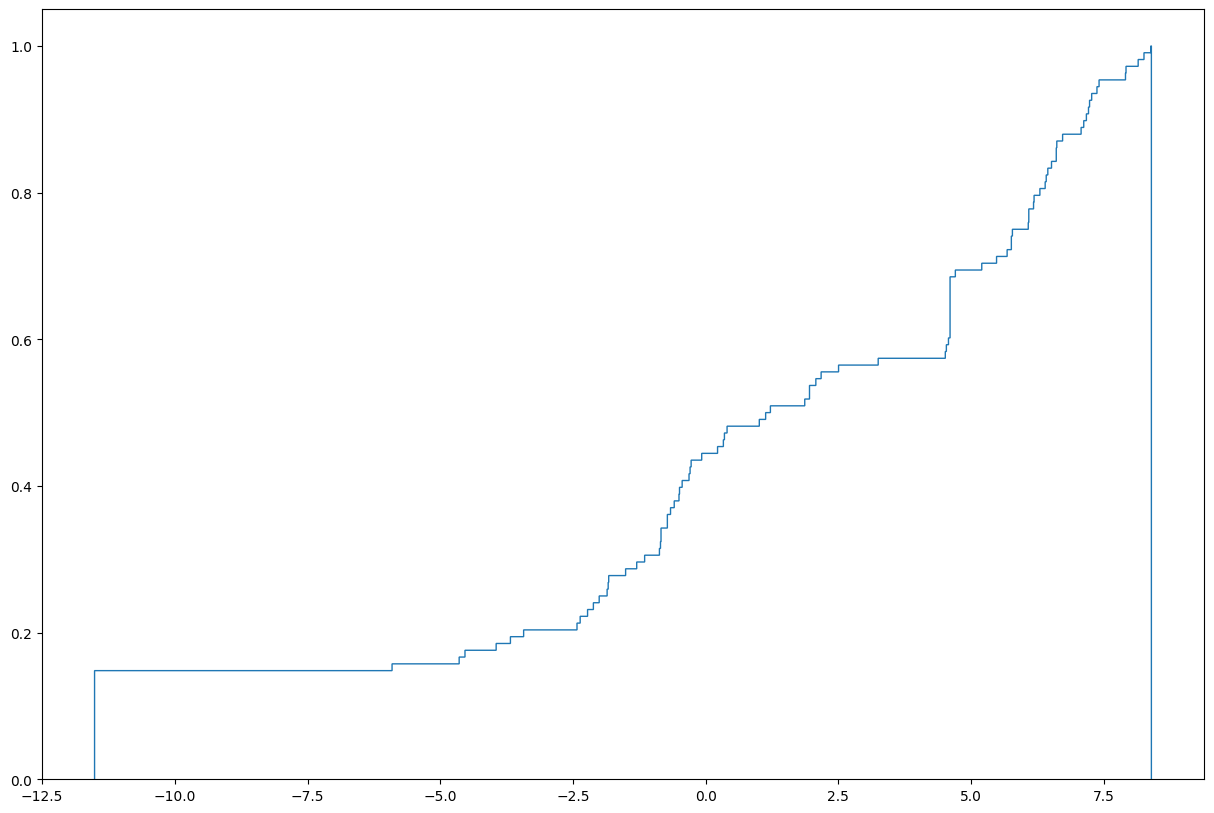

In [26]:
from models import SymbolicGaussianDiffusion, PointNetConfig

pconfig = PointNetConfig(
    embeddingSize=n_embd,
    numberofPoints=numPoints,
    numberofVars=numVars,
    numberofYs=numYs,
)
model = SymbolicGaussianDiffusion(
    tnet_config=pconfig,
    vocab_size=train_dataset.vocab_size,
    max_seq_len=blockSize,
    padding_idx=test_dataset.paddingID,
    max_num_vars=9,
    n_layer=8,
    n_head=8,
    n_embd=n_embd,
    timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    set_transformer=True,
).to(device)

model_path = "/content/drive/MyDrive/Colab/STAT946_proj/models/diffusym8/1_5_var_set_transformer"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
fName="/content/drive/MyDrive/Colab/STAT946_proj/results/diffusym8/ddim_step_1/1_5_var_set_transformer.txt"
test_results = run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconfig)